### Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from copy import deepcopy
import time

from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import tensorflow as tf
from tensorflow import keras
from kerastuner.tuners import RandomSearch

from gensim import downloader
import gensim
from gensim.models import Word2Vec

from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC



import fun_encoding as fe
import fun_metrics as fm
import fun_features_engineering 

#https://bmcmedinformdecismak.biomedcentral.com/articles/10.1186/s12911-020-1044-0

C:\Users\Paul\AppData\Local\Temp\ipykernel_1452\849887276.py:13: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [2]:
URL_PREFIXE : str = 'https://raw.githubusercontent.com/Franck-Dernoncourt/pubmed-rct/master/PubMed_20k_RCT/'
URL_TRAIN : str = URL_PREFIXE + 'train.txt'
URL_TEST : str = URL_PREFIXE + 'test.txt'

In [5]:
# Creation DataFrame
# adapt here to put 200k data
df_train = fe.create_df_clean(URL_TRAIN)
df_test = fe.create_df_clean(URL_TEST)

In [7]:
def fit_and_compare_pca_and_model(clf, model1, model2) :

    '''
    This function takes a classifier clf, two models (model1 and model2 in this project) and
    DISPLAYS 4 plots with on each ones the mean precision, recall and f1-score and the accuracy 
    for each of these : model 1, model1_pca, model 2, model2_pca.
    (4 plots of 4 barplots)
    The function also provides fit times for model2 and model2_pca.

    Args:
        clf : sklearn classifier
            The classifier
        model1 : w2v model
        model2 : w2v model

    Returns:
        Display the barplots.
    '''

    X_train1, y_train1, X_test1, y_test1 = fun_features_engineering.get_final_data(df_train, df_test, model1, to_do_pca=False)
    X_train_pca1, y_train_pca1, X_test_pca1, y_test_pca1 = fun_features_engineering.get_final_data(df_train, df_test, model1, to_do_pca=True)
    X_train2, y_train2, X_test2, y_test2 = fun_features_engineering.get_final_data(df_train, df_test, model2, to_do_pca=False)
    X_train_pca2, y_train_pca2, X_test_pca2, y_test_pca2 = fun_features_engineering.get_final_data(df_train, df_test, model2, to_do_pca=True)

    # copy of the clf in parameter : can't be a simple copy. We have to use deepcopy().
    clf_a = deepcopy(clf)
    clf_b = deepcopy(clf)
    clf_c = deepcopy(clf)

    clf1 = clf.fit( X_train1, y_train1 )
    clf_pca1 = clf_a.fit( X_train_pca1, y_train_pca1 )
    start = time.time()
    clf2 = clf_b.fit( X_train2, y_train2 )
    end = time.time()
    start_pca = time.time()
    clf_pca2 =clf_c.fit( X_train_pca2, y_train_pca2 )
    end_pca = time.time()

    pred1 = clf1.predict(X_test1)
    pred_pca1 = clf_pca1.predict(X_test_pca1)
    pred2 = clf2.predict(X_test2)
    pred_pca2 = clf_pca2.predict(X_test_pca2)

    mean_p1 = precision_score(y_test1, pred1, average='macro')
    mean_p_pca1 = precision_score(y_test_pca1, pred_pca1, average='macro')
    mean_p2 = precision_score(y_test2, pred2, average='macro')
    mean_p_pca2 = precision_score(y_test_pca2, pred_pca2, average='macro')
    prec = [mean_p1, mean_p_pca1, mean_p2, mean_p_pca2]

    mean_r1 = recall_score(y_test1, pred1, average='macro')
    mean_r_pca1 = recall_score(y_test_pca1, pred_pca1, average='macro')
    mean_r2 = recall_score(y_test2, pred2, average='macro')
    mean_r_pca2 = recall_score(y_test_pca2, pred_pca2, average='macro')
    rec = [ mean_r1, mean_r_pca1, mean_r2, mean_r_pca2 ]

    mean_f1 = f1_score(y_test1, pred1, average='macro')
    mean_f_pca1 = f1_score(y_test_pca1, pred_pca1, average='macro')
    mean_f2 = f1_score(y_test2, pred2, average='macro')
    mean_f_pca2 = f1_score(y_test_pca2, pred_pca2, average='macro')
    f1s = [ mean_f1, mean_f_pca1, mean_f2, mean_f_pca2 ]

    acc1 = accuracy_score(y_test1, pred1)
    acc_pca1 = accuracy_score(y_test_pca1, pred_pca1)
    acc2 = accuracy_score(y_test2, pred2)
    acc_pca2 = accuracy_score(y_test_pca2, pred_pca2)
    acc = [acc1, acc_pca1, acc2, acc_pca2]
 
    indices = np.arange(len(prec))
    bar_width = 0.35
    fig, axes = plt.subplots(2, 2, figsize=(8, 6))

    axes[0, 0].bar(['Model1', 'Model1_pca', 'Model2', 'Model2_pca'], prec)
    axes[0, 0].set_title('Precision mean')
    axes[0, 0].set_xticks(indices)
    axes[0, 0].set_xticklabels(['Model1', 'Model1_pca', 'Model2', 'Model2_pca'])

    axes[1, 0].bar(['Model1', 'Model1_pca', 'Model2', 'Model2_pca'], rec)
    axes[1, 0].set_title('F1-score mean')
    axes[1, 0].set_xticks(indices)
    axes[1, 0].set_xticklabels(['Model1', 'Model1_pca', 'Model2', 'Model2_pca'])

    axes[0, 1].bar(['Model1', 'Model1_pca', 'Model2', 'Model2_pca'], f1s)
    axes[0, 1].set_title('Recall mean')
    axes[0, 1].set_xticks(indices)
    axes[0, 1].set_xticklabels(['Model1', 'Model1_pca', 'Model2', 'Model2_pca'])

    axes[1, 1].bar(['Model1', 'Model1_pca', 'Model2', 'Model2_pca'], acc)
    axes[1, 1].set_title('Models accuracy')
    axes[1, 1].set_xticks(indices)
    axes[1, 1].set_xticklabels(['Model1', 'Model1_pca', 'Model2', 'Model2_pca'])
    plt.tight_layout()
    plt.show()

    print( f"Time elapsed for Model 2 fit : {end-start:.2f}s // Model 2 pca : {end_pca - start_pca:.2f}s" )


# Models

In [9]:
# Load the models
# Model1 : homemade w2v 200d
# Model2 : internet w2v 100d

model1 : gensim.models.word2vec.Word2Vec = fe.create_word_embeddings(df_train['sentence'].tolist(), epochs=3)
model2 : gensim.models.word2vec.Word2Vec = Word2Vec.load('./proj_100d_external/w2v_OA_CR_100d.bin')

# Download the model 2 from the following link :
# https://huggingface.co/garyw/clinical-embeddings-100d-w2v-cr/tree/main
# you need to take the 3 files :
# w2v_OA_CR_100d.bin
# w2v_OA_CR_100d.bin.trainables.syn1neg.npy
# w2v_OA_CR_100d.bin.wv.vectors.npy
# put them in the proj_100d_external folder, and you're good to go.

# if you're having trouble with model1, we have a .bin file in the folder ( model_w2v_1.bin )
# the internet model is linked in the report (huggigface)

### Random Forest

In [10]:
clf = RandomForestClassifier(n_jobs=-1)

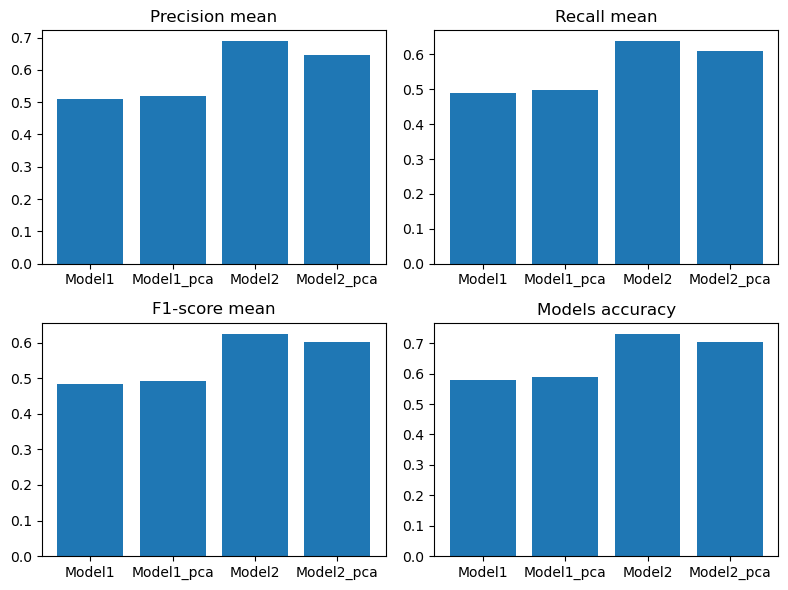

Time elapsed for Model 2 fit : 70.51s // Model 2 pca : 17.90s


In [11]:
fit_and_compare_pca_and_model(clf, model1, model2)

### Random Forest optimization

In [12]:
X_train, y_train, X_test, y_test = fun_features_engineering.get_final_data(df_train, df_test, model2, to_do_pca=True, additionnal_features=True)

RandomizedSearchCV() and its output (markdown because the execution si very long)

In [13]:
# param_dist = {
#     'n_estimators': [100, 300, 500],  # Nombre d'arbres dans la forêt
#     'max_depth': [None],  # we let min_sample_split take care of the depth
#     'min_samples_split': [2, 5, 10, 100],
#     'min_samples_leaf': [1, 10],
#     'bootstrap': [True, False],  
#     'n_jobs' : [-1]
# }

# rf = RandomForestClassifier()

# search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1)

# search.fit(X_train, y_train)  # Remplacez X_train et y_train par vos données d'entraînement

# print("Best hyperparameters:", search.best_params_)

# accuracy = search.score(X_test, y_test) 
# print("Accuracy:", accuracy)

# OUTPUT GENERATED :

# Fitting 3 folds for each of 48 candidates, totalling 144 fits
# Best hyperparameters: {'n_jobs': -1, 'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None, 'bootstrap': False}
# Accuracy: 0.7075493612078978

We decided to further fit the Random Classifier on model2, but concentrating solely on max_depth as it seems that the overfitting was very high.<br>
We will use the best hyperparameters found above and add an analysis on the max_depth.

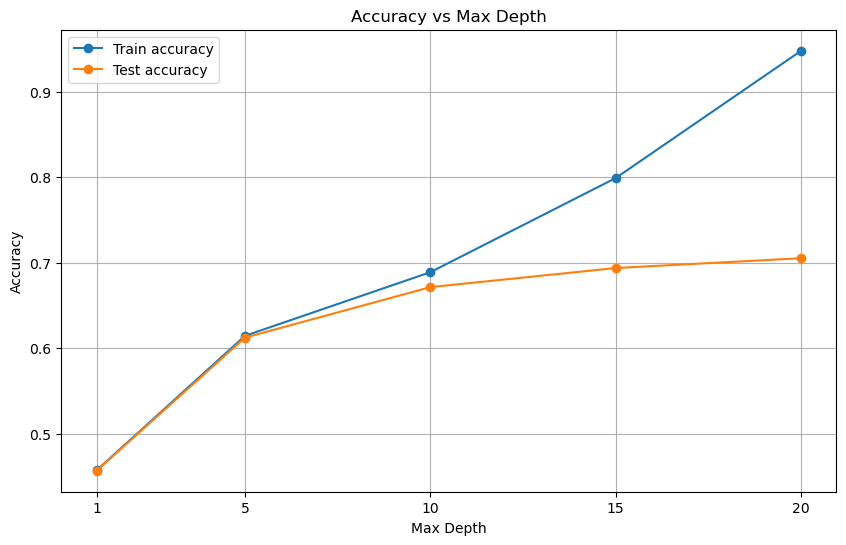

In [14]:
max_depth_values = [1, 5, 10, 15, 20]

train_accuracy_scores = []
test_accuracy_scores = []


for max_depth in max_depth_values:

    clf = RandomForestClassifier(n_estimators=500, max_features=5, min_samples_split=2, min_samples_leaf=1, bootstrap=False, max_depth=max_depth, n_jobs=-1)
    clf.fit(X_train, y_train)

    pred_train = clf.predict(X_train)
    pred_test = clf.predict(X_test)

    train_accuracy = accuracy_score(y_train, pred_train)
    test_accuracy = accuracy_score(y_test, pred_test)

    train_accuracy_scores.append(train_accuracy)
    test_accuracy_scores.append(test_accuracy)

plt.figure(figsize=(10, 6))
plt.plot(max_depth_values, train_accuracy_scores, marker='o', label='Train accuracy')
plt.plot(max_depth_values, test_accuracy_scores, marker='o', label='Test accuracy')
plt.title('Accuracy vs Max Depth')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.grid(True)
plt.xticks(max_depth_values)
plt.legend()
plt.show()

In [15]:
# add or remove class_weight (both presented in the rapport)
clf = RandomForestClassifier(n_estimators=500, max_features=5, min_samples_split=2, min_samples_leaf=1, bootstrap=False, max_depth=14, class_weight = 'balanced', n_jobs=-1)

In [16]:
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, class_weight='balanced', max_depth=14,
                       max_features=5, n_estimators=500, n_jobs=-1)

Mean accuracy : 0.6789779326364692
              precision    recall  f1-score   support

           0       0.64      0.36      0.46      3621
           1       0.48      0.75      0.58      4571
           2       0.79      0.75      0.77      9897
           3       0.39      0.48      0.43      2333
           4       0.83      0.73      0.78      9713

    accuracy                           0.68     30135
   macro avg       0.63      0.62      0.61     30135
weighted avg       0.71      0.68      0.68     30135



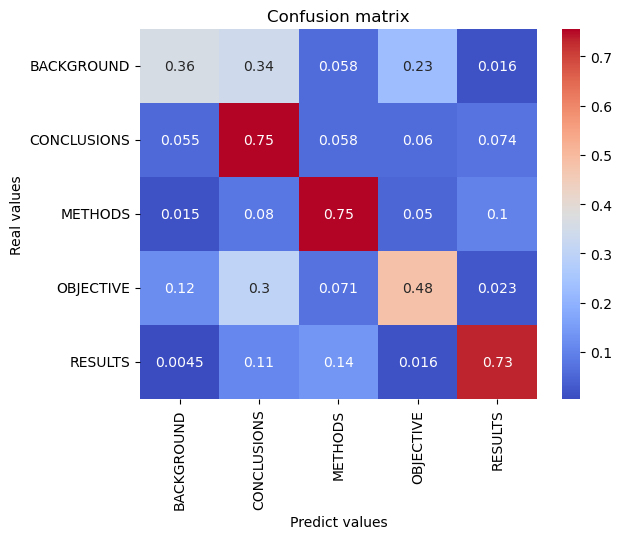

In [17]:
fm.display_metrics_and_confusion_matrix(clf, X_test, y_test)

### SVC

In [18]:
# # VERY LONG, + results mediocre.

# from sklearn.ensemble import BaggingClassifier
# base_classifier = SVC(random_state=42)

# # Create a BaggingClassifier with a classifier (SVC here) inside
# multi_svc = BaggingClassifier(base_classifier, n_estimators=6, n_jobs=-1, random_state=42)


In [19]:
# fit_and_compare_pca_and_model(multi_svc, model1, model2)

# Deep Learning Models

In [20]:
# Data for the Deep Learning models (cleaned from additionnal features)
X_train1, y_train1, X_test1, y_test1 = fun_features_engineering.get_final_data(df_train, df_test, model1, to_do_pca=False, additionnal_features=False)
print('Model 1 shape : ', X_train1.shape)
X_train2, y_train2, X_test2, y_test2 = fun_features_engineering.get_final_data(df_train, df_test, model2, to_do_pca=False, additionnal_features=False)
print('Model 2 shape : ', X_train2.shape)

Model 1 shape :  (180040, 200)
Model 2 shape :  (180040, 100)


### RNN
Data comes in w2v'ed <b> and without the additionnal features.</b> (indeed, we let the neural network capture those features), and goes through the CNN. We extract the usuals metrics and compare them.

#### Model1

In [21]:
RNN1 = Sequential()
RNN1.add(Dense(64, input_dim=X_train1.shape[1], activation='relu'))
RNN1.add(Dropout(0.5))
RNN1.add(Dense(32, activation='relu'))
RNN1.add(Dropout(0.5)),
RNN1.add(Dense(5, activation='softmax')) 

# Compiler le model
RNN1.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# optimizer : adam, SGD, RMSprop

RNN1.fit(X_train1, y_train1, epochs=10, batch_size=32)

########################
loss1, accuracy1 = RNN1.evaluate(X_test1, y_test1)
print(f'Loss: {loss1}, Accuracy: {accuracy1}')

#####################

predictions1 = RNN1.predict(X_test1)
predicted_labels1 = tf.argmax(predictions1, axis=1)



Epoch 1/10


5627/5627 [==============================] - 9s 1ms/step - loss: 1.2837 - accuracy: 0.4562
Epoch 2/10
5627/5627 [==============================] - 8s 1ms/step - loss: 1.2418 - accuracy: 0.4705
Epoch 3/10
5627/5627 [==============================] - 8s 1ms/step - loss: 1.2374 - accuracy: 0.4735
Epoch 4/10
5627/5627 [==============================] - 8s 1ms/step - loss: 1.2333 - accuracy: 0.4753
Epoch 5/10
5627/5627 [==============================] - 8s 1ms/step - loss: 1.2294 - accuracy: 0.4764
Epoch 6/10
5627/5627 [==============================] - 8s 1ms/step - loss: 1.2271 - accuracy: 0.4764
Epoch 7/10
5627/5627 [==============================] - 8s 1ms/step - loss: 1.2263 - accuracy: 0.4775
Epoch 8/10
5627/5627 [==============================] - 8s 1ms/step - loss: 1.2247 - accuracy: 0.4770
Epoch 9/10
5627/5627 [==============================] - 8s 1ms/step - loss: 1.2233 - accuracy: 0.4768
Epoch 10/10
942/942 [==============================] - 1s 1ms/step - loss: 1.1

#### model2

In [22]:
RNN2 = Sequential()
RNN2.add(Dense(64, input_dim=X_train2.shape[1], activation='relu'))
RNN2.add(Dropout(0.5))
RNN2.add(Dense(32, activation='relu'))
RNN2.add(Dense(5, activation='softmax')) 

# Compiler le model
RNN2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# optimizer : adam, SGD, RMSprop

RNN2.fit(X_train2, y_train2, epochs=10, batch_size=32)

########################
loss2, accuracy2 = RNN2.evaluate(X_test2, y_test2)
print(f'Loss: {loss2}, Accuracy: {accuracy2}')

#####################

predictions2 = RNN2.predict(X_test2)
predicted_labels2 = tf.argmax(predictions2, axis=1)

Epoch 1/10
5627/5627 [==============================] - 8s 1ms/step - loss: 0.8627 - accuracy: 0.6655
Epoch 2/10
5627/5627 [==============================] - 7s 1ms/step - loss: 0.7600 - accuracy: 0.7096
Epoch 3/10
5627/5627 [==============================] - 7s 1ms/step - loss: 0.7366 - accuracy: 0.7196
Epoch 4/10
5627/5627 [==============================] - 7s 1ms/step - loss: 0.7220 - accuracy: 0.7241
Epoch 5/10
5627/5627 [==============================] - 8s 1ms/step - loss: 0.7125 - accuracy: 0.7296
Epoch 6/10
5627/5627 [==============================] - 7s 1ms/step - loss: 0.7070 - accuracy: 0.7313
Epoch 7/10
5627/5627 [==============================] - 8s 1ms/step - loss: 0.7021 - accuracy: 0.7339
Epoch 8/10
5627/5627 [==============================] - 8s 1ms/step - loss: 0.6990 - accuracy: 0.7353
Epoch 9/10
5627/5627 [==============================] - 8s 1ms/step - loss: 0.6966 - accuracy: 0.7363
Epoch 10/10
942/942 [==============================] - 1s 1ms/step - loss: 0.6505 

#### Evaluation

 92/942 [=>............................] - ETA: 0s

c:\Users\Paul\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Paul\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


942/942 [==============================] - 1s 1ms/step


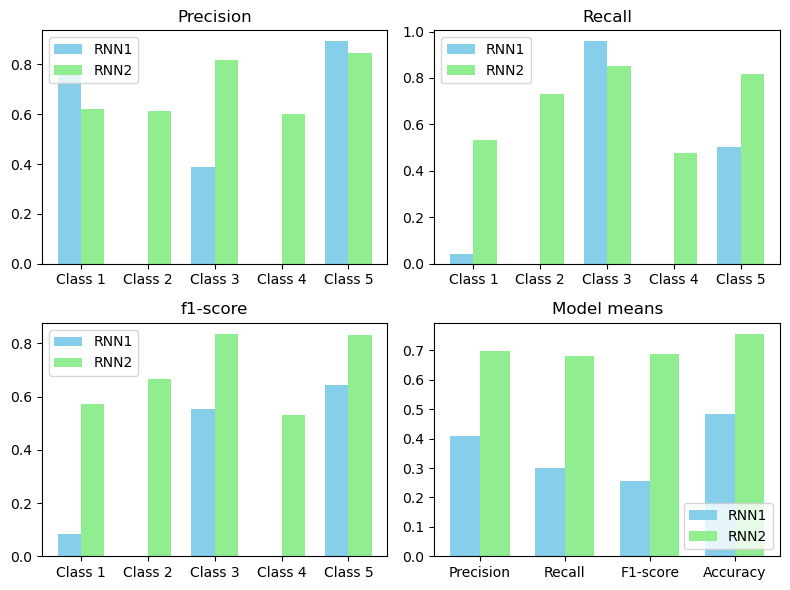

In [27]:
fm.keras_metrics_compare(RNN1, X_test1, y_test1, RNN2, X_test2, y_test2, 'RNN1', 'RNN2')


### CNN

#### Model1

In [28]:
input_shape = (X_train1.shape[1],1,)  # shape of the data

# Create the CNN model
CNN1 = models.Sequential([
    layers.Conv1D(filters=64, kernel_size=5, activation='relu', input_shape=input_shape),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(filters=64, kernel_size=5, activation='relu'),
    layers.MaxPooling1D(pool_size=2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(5, activation='softmax')  
])

# Compile the model
CNN1.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
CNN1.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 196, 64)           384       
                                                                 
 max_pooling1d (MaxPooling1  (None, 98, 64)            0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 94, 64)            20544     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 47, 64)            0         
 g1D)                                                            
                                                                 
 flatten (Flatten)           (None, 3008)              0         
                                                                 
 dense_6 (Dense)             (None, 128)             

In [29]:
# Train the model
history = CNN1.fit(
    X_train1,
    y_train1,
    validation_split=0.2,
    epochs=10,
)

# Evaluate the model
test_loss1, test_accuracy1 = CNN1.evaluate(X_test1, y_test1)
print("Test Loss:", test_loss1)
print("Test Accuracy:", test_accuracy1)

Epoch 1/10
4501/4501 [==============================] - 28s 6ms/step - loss: 1.2266 - accuracy: 0.4699 - val_loss: 1.1993 - val_accuracy: 0.4841
Epoch 2/10
4501/4501 [==============================] - 27s 6ms/step - loss: 1.1944 - accuracy: 0.4849 - val_loss: 1.2123 - val_accuracy: 0.4746
Epoch 3/10
4501/4501 [==============================] - 27s 6ms/step - loss: 1.1890 - accuracy: 0.4873 - val_loss: 1.1917 - val_accuracy: 0.4823
Epoch 4/10
4501/4501 [==============================] - 26s 6ms/step - loss: 1.1857 - accuracy: 0.4887 - val_loss: 1.1902 - val_accuracy: 0.4853
Epoch 5/10
4501/4501 [==============================] - 26s 6ms/step - loss: 1.1829 - accuracy: 0.4897 - val_loss: 1.1906 - val_accuracy: 0.4876
Epoch 6/10
4501/4501 [==============================] - 26s 6ms/step - loss: 1.1809 - accuracy: 0.4906 - val_loss: 1.1878 - val_accuracy: 0.4850
Epoch 7/10
4501/4501 [==============================] - 27s 6ms/step - loss: 1.1794 - accuracy: 0.4901 - val_loss: 1.1871 - val_ac

#### Model2

In [30]:
input_shape = (X_train2.shape[1],1,)  # shape of the data

CNN2 = models.Sequential([
    layers.Conv1D(filters=64, kernel_size=5, activation='relu', input_shape=input_shape),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(filters=64, kernel_size=5, activation='relu'),
    layers.MaxPooling1D(pool_size=2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(5, activation='softmax')  
])

CNN2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

CNN2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 96, 64)            384       
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 48, 64)            0         
 g1D)                                                            
                                                                 
 conv1d_3 (Conv1D)           (None, 44, 64)            20544     
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 22, 64)            0         
 g1D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 1408)              0         
                                                                 
 dense_8 (Dense)             (None, 128)              

In [31]:
# Train the model
history = CNN2.fit(
    X_train2,
    y_train2,
    validation_split=0.2,
    epochs=10
)

# Evaluate the model
test_loss2, test_accuracy2 = CNN2.evaluate(X_test2, y_test2)
print("Test Loss:", test_loss2)
print("Test Accuracy:", test_accuracy2)

Epoch 1/10
4501/4501 [==============================] - 20s 4ms/step - loss: 0.7899 - accuracy: 0.6947 - val_loss: 0.7128 - val_accuracy: 0.7261
Epoch 2/10
4501/4501 [==============================] - 19s 4ms/step - loss: 0.6832 - accuracy: 0.7399 - val_loss: 0.6732 - val_accuracy: 0.7439
Epoch 3/10
4501/4501 [==============================] - 19s 4ms/step - loss: 0.6518 - accuracy: 0.7535 - val_loss: 0.6423 - val_accuracy: 0.7558
Epoch 4/10
4501/4501 [==============================] - 19s 4ms/step - loss: 0.6282 - accuracy: 0.7618 - val_loss: 0.6631 - val_accuracy: 0.7512
Epoch 5/10
4501/4501 [==============================] - 19s 4ms/step - loss: 0.6125 - accuracy: 0.7680 - val_loss: 0.6227 - val_accuracy: 0.7643
Epoch 6/10
4501/4501 [==============================] - 19s 4ms/step - loss: 0.5992 - accuracy: 0.7738 - val_loss: 0.6226 - val_accuracy: 0.7644
Epoch 7/10
4501/4501 [==============================] - 19s 4ms/step - loss: 0.5881 - accuracy: 0.7780 - val_loss: 0.6165 - val_ac

In [32]:
# the CNN gives for each sentence to test a probability for the sentence to be from each class.
# ex : "this is a sentence" -> [0.01, 0.5, 0.8, 0.25, 0.14]
# We take the highest probability (tf.argmax) and say that this is our prediction 

predictions2 = CNN2.predict(X_test2)
predicted_labels2 = tf.argmax(predictions2, axis=1)
print(classification_report(y_test2, predicted_labels2))

942/942 [==============================] - 2s 2ms/step
              precision    recall  f1-score   support

           0       0.59      0.63      0.61      3621
           1       0.65      0.73      0.69      4571
           2       0.83      0.88      0.85      9897
           3       0.70      0.36      0.48      2333
           4       0.85      0.83      0.84      9713

    accuracy                           0.77     30135
   macro avg       0.72      0.68      0.69     30135
weighted avg       0.77      0.77      0.76     30135



#### Evaluation

942/942 [==============================] - 2s 2ms/step


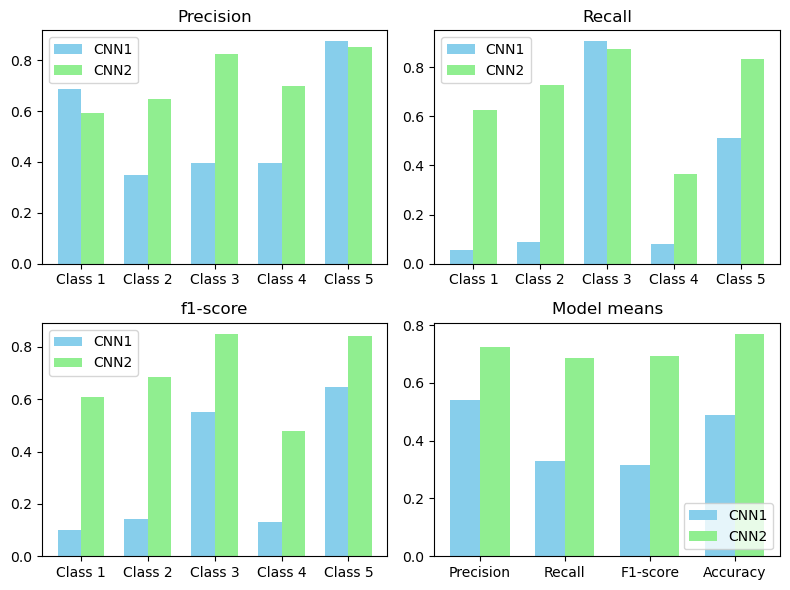

In [33]:
fm.keras_metrics_compare(CNN1, X_test1, y_test1, CNN2, X_test2, y_test2, 'CNN1', 'CNN2')

### NN Evaluation

942/942 [==============================] - 2s 2ms/step


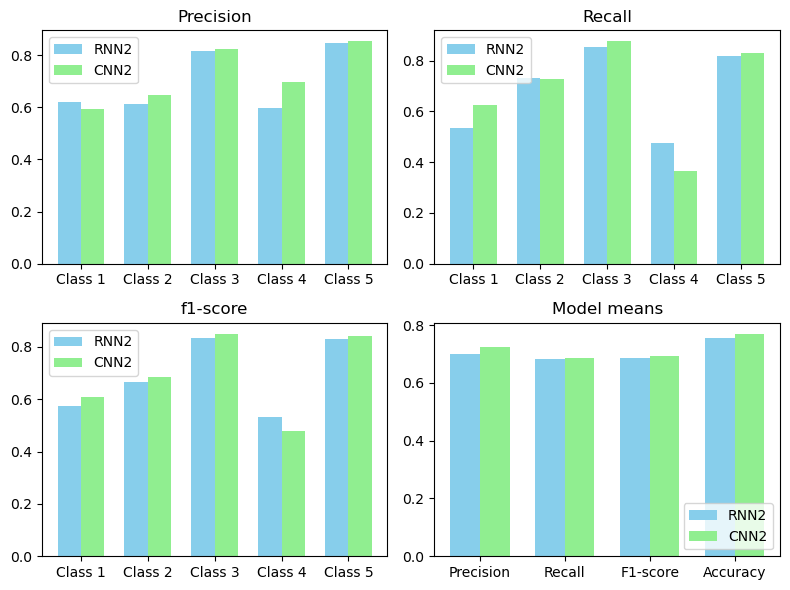

In [34]:
fm.keras_metrics_compare(RNN2, X_test2, y_test2, CNN2, X_test2, y_test2, 'RNN2', 'CNN2')